# 🧩 KNN Training Pipeline (Flow chuẩn)

Flow bao gồm:
1) Load & đọc dữ liệu  
2) Thống kê & trực quan hóa (EDA)  
3) Xử lý dữ liệu (cleaning, encoding, scaling, split train/test)  
4) Thử nhiều model để so sánh hiệu suất → có biểu đồ so sánh  
5) Train KNN với cross-validation (GridSearchCV), lưu model & log CSV  
6) Đánh giá & kiểm thử KNN (classification report, confusion matrix, test accuracy)


## 1) Load & đọc dữ liệu

In [1]:

import os
import pandas as pd

# ⚙️ Cấu hình đường dẫn dữ liệu
# Mặc định tìm 'data.csv' trong cùng thư mục notebook.
DATA_PATH = "../Recommend_size/fake_size_data_1000.csv"  # đổi nếu cần

df = pd.read_csv(DATA_PATH)
print("✅ Đã đọc dữ liệu:", DATA_PATH)
df.head()


✅ Đã đọc dữ liệu: ../Recommend_size/fake_size_data_1000.csv


,height,weight,gender,chest,waist,shoulder,size
0,1.81,75,Nam,120,120,55,XL
1,1.56,46,Nam,98,101,49,XS
2,1.63,81,Nam,115,114,55,L
3,1.67,85,Nữ,122,118,55,XL
4,1.65,88,Nam,112,116,54,L


## 2) Thống kê & trực quan hóa (EDA)

,height,weight,size
count,699.000000,699.000000,699
unique,NaN,NaN,6
top,NaN,NaN,XL
freq,NaN,NaN,203
mean,1.701359,73.507868,NaN
std,0.108035,18.697513,NaN
min,1.480000,40.000000,NaN
25%,1.610000,58.000000,NaN
50%,1.700000,74.000000,NaN
75%,1.790000,88.000000,NaN


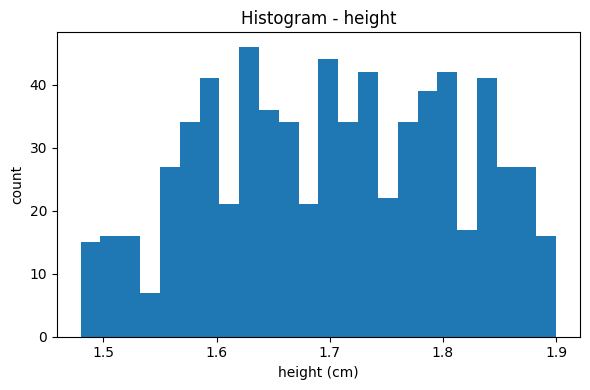

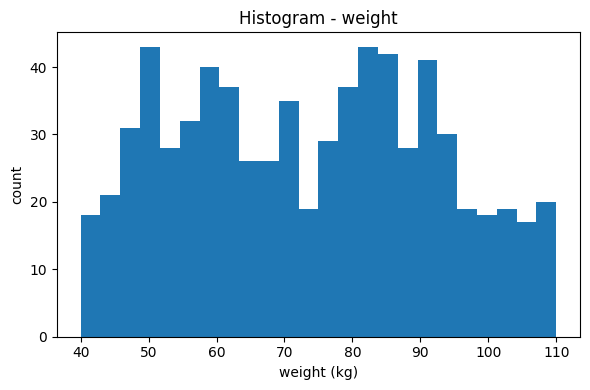

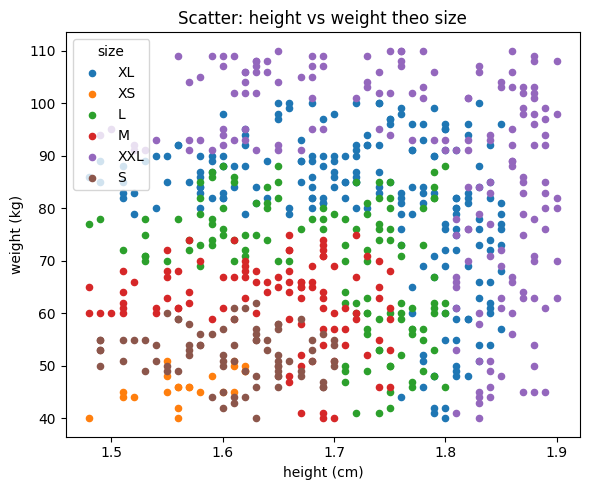

In [2]:

import matplotlib.pyplot as plt

# Chuẩn hóa tên cột nếu là tiếng Việt
rename_map = {'chiều cao': 'height', 'cân nặng': 'weight'}
for src, dst in rename_map.items():
    if src in df.columns and dst not in df.columns:
        df.rename(columns={src: dst}, inplace=True)

assert 'height' in df.columns and 'weight' in df.columns, "Cần có cột 'height' và 'weight' (hoặc 'chiều cao','cân nặng')."
assert 'size'   in df.columns, "Cần có cột nhãn 'size'."

display(df[['height','weight','size']].describe(include='all'))

# Histogram cho height & weight
plt.figure(figsize=(6,4))
plt.hist(df['height'].dropna(), bins=24)
plt.title('Histogram - height'); plt.xlabel('height (cm)'); plt.ylabel('count')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.hist(df['weight'].dropna(), bins=24)
plt.title('Histogram - weight'); plt.xlabel('weight (kg)'); plt.ylabel('count')
plt.tight_layout(); plt.show()

# Scatter height vs weight theo size
plt.figure(figsize=(6,5))
for label in df['size'].unique():
    sub = df[df['size'] == label]
    plt.scatter(sub['height'], sub['weight'], s=20, label=str(label))
plt.title('Scatter: height vs weight theo size')
plt.xlabel('height (cm)'); plt.ylabel('weight (kg)')
plt.legend(title='size')
plt.tight_layout(); plt.show()


## 3) Xử lý dữ liệu (cleaning, encoding, scaling, split train/test)

In [3]:

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Lấy đúng 3 cột cần thiết & loại NaN
df_proc = df[['height','weight','size']].dropna().copy()
df_proc['height'] = df_proc['height'].astype(float)
df_proc['weight'] = df_proc['weight'].astype(float)

# Loại outliers theo IQR trên height & weight
Q1 = df_proc[['height','weight']].quantile(0.25)
Q3 = df_proc[['height','weight']].quantile(0.75)
IQR = Q3 - Q1
mask = ~(((df_proc[['height','weight']] < (Q1 - 1.5*IQR)) | (df_proc[['height','weight']] > (Q3 + 1.5*IQR))).any(axis=1))
df_clean = df_proc.loc[mask].reset_index(drop=True)
print(f'Số dòng sau khi loại outliers: {len(df_clean)} / {len(df_proc)}')

# Encode nhãn
le = LabelEncoder()
y = le.fit_transform(df_clean['size'])
X = df_clean[['height','weight']].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Chuẩn hóa
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

print('✅ Data ready:')
print('X_train:', X_train_s.shape, '| X_test:', X_test_s.shape)


Số dòng sau khi loại outliers: 699 / 699
✅ Data ready:
X_train: (559, 2) | X_test: (140, 2)


## 4) Thử nhiều model để so sánh hiệu suất → biểu đồ

KNN: 0.6429
LogisticRegression: 0.4714
SVM: 0.6714
RandomForest: 0.7143


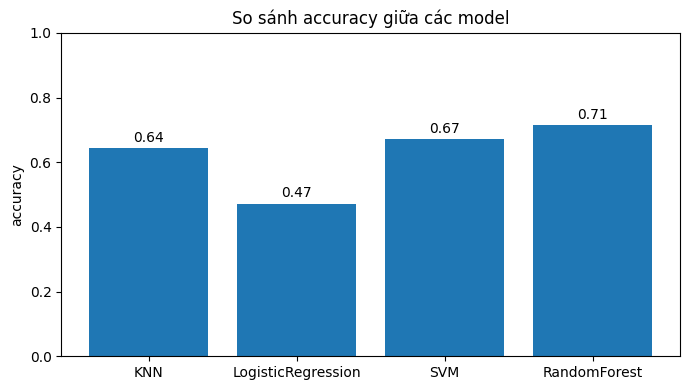

In [4]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(random_state=42)
}

accuracies = {}
for name, clf in models.items():
    # Model cần scale: KNN/LR/SVM dùng X_train_s; RF dùng X_train
    if name in ['KNN','LogisticRegression','SVM']:
        clf.fit(X_train_s, y_train)
        preds = clf.predict(X_test_s)
    else:
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies[name] = acc
    print(f'{name}: {acc:.4f}')

# Lưu & vẽ bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
names = list(accuracies.keys())
vals = [accuracies[k] for k in names]
plt.bar(names, vals)
plt.ylim(0,1); plt.ylabel('accuracy'); plt.title('So sánh accuracy giữa các model')
for i,v in enumerate(vals):
    plt.text(i, min(v+0.02, 0.98), f'{v:.2f}', ha='center')
plt.tight_layout(); plt.show()


## 5) Train KNN (GridSearchCV), lưu model & log CSV

Numeric features: ['height', 'weight', 'chest', 'waist', 'shoulder']
Categorical features: ['gender']
Best params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best CV accuracy: 0.9982

=== TEST METRICS ===
Accuracy: 1.0
F1-macro: 1.0

Classification report:
              precision    recall  f1-score   support

           L       1.00      1.00      1.00        25
           M       1.00      1.00      1.00        20
           S       1.00      1.00      1.00        15
          XL       1.00      1.00      1.00        41
          XS       1.00      1.00      1.00         4
         XXL       1.00      1.00      1.00        35

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140

Saved log CSV -> ../Recommend_size\rf_full_training_log.csv
Saved pipeline -> ../Recommend_size\rf_full_pipelin

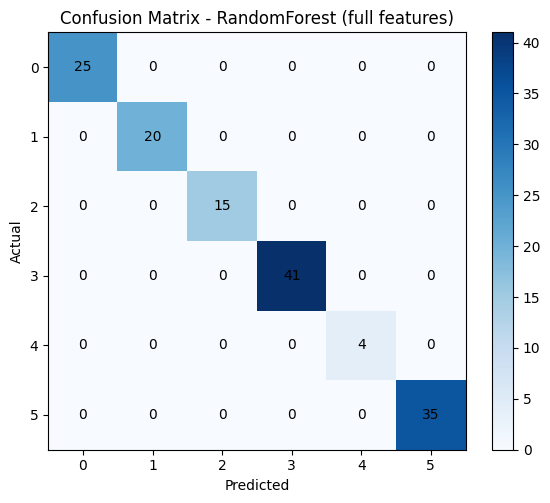

Saved confusion matrix image -> ../Recommend_size\rf_full_confusion_matrix.png


In [6]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# DATA_PATH  = "../Recommend_size/fake_size_data_1000.csv"         
OUTPUT_DIR = "../Recommend_size"                
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# df = pd.read_csv(DATA_PATH)

# Xác nhận cột nhãn
if "size" not in df.columns:
    raise KeyError("Thiếu cột nhãn 'size'.")

# Nếu có height/weight mà chưa có BMI -> tính
if "height" in df.columns and "weight" in df.columns and "BMI" not in df.columns:
    df_clean["BMI"] = df_clean["weight"] / ((df_clean["height"] / 100.0) ** 2)

# Lấy tất cả cột trừ nhãn làm feature
feature_cols = [c for c in df.columns if c != "size"]

# Drop cột rỗng toàn bộ (nếu có)
feature_cols = [c for c in feature_cols if not df[c].isna().all()]
df = df[feature_cols + ["size"]].dropna().copy()

# Cast numeric hợp lý
for c in feature_cols:
    # nếu là chuỗi số -> cố ép về số; nếu thật sự text (gender) sẽ giữ nguyên object
    if df[c].dtype == object:
        try:
            df[c] = pd.to_numeric(df[c])
        except Exception:
            pass

# Phân loại cột categorical/numeric
cat_cols = []
num_cols = []
for c in feature_cols:
    if df[c].dtype == object:
        cat_cols.append(c)
    else:
        num_cols.append(c)

# Trường hợp 'gender' là text Nam/Nữ -> để ở cat_cols (sẽ one-hot)
print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)

# Encode nhãn size
le = LabelEncoder()
y = le.fit_transform(df["size"])
X = df[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ColumnTransformer: OneHotEncoder cho cat, pass-through numeric
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)

# PIPELINE + GRIDSEARCH 
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", rf),
])

param_grid = {
    "rf__n_estimators": [200, 400],
    "rf__max_depth": [None, 10, 16],
    "rf__min_samples_split": [2, 4],
    "rf__min_samples_leaf": [1, 2],
    "rf__max_features": ["sqrt", "log2", None],
}

gs = GridSearchCV(
    pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=0
)
gs.fit(X_train, y_train)

best_pipe = gs.best_estimator_
print("Best params:", gs.best_params_)
print("Best CV accuracy:", round(gs.best_score_, 4))

# ĐÁNH GIÁ TEST
y_pred = best_pipe.predict(X_test)
acc  = accuracy_score(y_test, y_pred)
f1m  = f1_score(y_test, y_pred, average="macro")
labels_sorted = np.unique(y_test)
target_names  = le.inverse_transform(labels_sorted)

print("\n=== TEST METRICS ===")
print("Accuracy:", round(acc, 4))
print("F1-macro:", round(f1m, 4))
print("\nClassification report:")
print(classification_report(y_test, y_pred, labels=labels_sorted, target_names=target_names))

# LƯU LOG CSV 
rep_dict = classification_report(
    y_test, y_pred, output_dict=True, labels=labels_sorted, target_names=target_names
)
log_df = pd.DataFrame(rep_dict).transpose().reset_index().rename(columns={"index": "label"})
log_df.insert(1, "acc_overall", acc)
log_df.insert(2, "f1_macro_overall", f1m)

log_csv = os.path.join(OUTPUT_DIR, "rf_full_training_log.csv")
log_df.to_csv(log_csv, index=False)
print("Saved log CSV ->", log_csv)

# LƯU PIPELINE + LABEL ENCODER 
model_pkl = os.path.join(OUTPUT_DIR, "rf_full_pipeline.pkl")
le_pkl    = os.path.join(OUTPUT_DIR, "rf_full_label_encoder.pkl")
joblib.dump(best_pipe, model_pkl)
joblib.dump(le,        le_pkl)
print("Saved pipeline ->", model_pkl)
print("Saved label encoder ->", le_pkl)

# CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - RandomForest (full features)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
for (i,j),v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
cm_path = os.path.join(OUTPUT_DIR, "rf_full_confusion_matrix.png")
plt.savefig(cm_path, dpi=150)
plt.show()
print("Saved confusion matrix image ->", cm_path)
